In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/Shareddrives/CSCI 461/processed'
#%ls processed/*


Mounted at /content/drive/
/content/drive/Shareddrives/CSCI 461/processed


# DATA MANIPULATION

In [ ]:
# Importing the data

data = pd.read_csv("combined_ohe.csv")
#data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
#print(data.head())

In [ ]:
edu_matrix = data[["highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license"]]
data["edu_categorical"] = edu_matrix.idxmax(axis=1)

In [ ]:
# making education binary

educationBinary = \
{   
    "highedcert_associate degree": 1,
    "highedcert_bachelor degree": 1,
    "highedcert_high school or ged": 1,
    "highedcert_higher degree": 1,
    "highedcert_none of the above":0,
    "highedcert_vocational certificate": 1,
    "highedcert_vocational license": 1
}
data['edu_binary'] = data["edu_categorical"].map(educationBinary) 

In [ ]:
# dropping overlap variables (and other outcome features, recnumbr)
data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license","edu_categorical", 'homeless_no','homeless_yes','subabuse_no',
                   'subabuse_yes', 'incarc_no', 'incarc_yes', 'edu_categorical'], axis=1, inplace=True)
#subabuse
# data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
#                   "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
#                   "highedcert_vocational license","edu_categorical", 'edu_binary','homeless_no','homeless_yes', 'subabuse_no', 'incarc_no', 'incarc_yes', 'edu_categorical'], axis=1, inplace=True)
#data.nunique()

In [ ]:
# drop services (OPTIONAL)
data.drop(columns=['specedsv_No',
 'specedsv_Yes',
 'ilnasv_No',
 'ilnasv_Yes',
 'acsuppsv_No',
 'acsuppsv_Yes',
 'psedsuppsv_No',
 'psedsuppsv_Yes',
 'careersv_No',
 'careersv_Yes',
 'emplytrsv_No',
 'emplytrsv_Yes',
 'budgetsv_No',
 'budgetsv_Yes',
 'housedsv_No',
 'housedsv_Yes',
 'hlthedsv_No',
 'hlthedsv_Yes',
 'famsuppsv_No',
 'famsuppsv_Yes',
 'mentorsv_No',
 'mentorsv_Yes',
 'silsv_No',
 'silsv_Yes',
 'rmbrdfasv_No',
 'rmbrdfasv_Yes',
 'educfinasv_No',
 'educfinasv_Yes',
 'othrfinasv_No',
 'othrfinasv_Yes'], axis=1, inplace=True)

In [ ]:
# filtering for age 19+ and balancing the class
data = data[data['age']>18].sort_values('age', ascending = False).sort_values('edu_binary').iloc[:1084*2,:]

## SETTING UP MODELS

In [ ]:
# Setting target variables
data = data.sample(frac=1)
y = data.loc[:,"edu_binary"]
X = data.loc[:,data.columns != "edu_binary"]

In [ ]:
#  TEST & TRAIN SPLIT
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,) # check the shape of X_train and X_test

# Feature scaling 
scaler = MinMaxScaler((-1,1))
X['age'] = scaler.fit_transform(np.array(X['age']).reshape(-1, 1))
y = data.loc[:,"edu_binary"]
X = data.loc[:,data.columns != "edu_binary"]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Prep to cross validate

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# Folds for cross-val
k = 5

In [ ]:
# Functions to print CM heat map and performnce results

from sklearn.metrics import confusion_matrix
#from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
#import sklearn
import seaborn as sns

def my_cm(y,y_pred,k=5):

  cm = confusion_matrix(y, y_pred)
  cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
  return sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

def my_scores(mod, X, y,k=5):
  scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
  scores = cross_validate(mod, X, y, cv=k,scoring=scoring)
  print("accuracy:",sum(scores["test_accuracy"])/k)
  print("precision:",sum(scores["test_precision"])/k)
  print("auc:",sum(scores["test_roc_auc"])/k)
  print("recall:",sum(scores["test_recall"])/k)
  print("f1:",sum(scores["test_f1"])/k)
  return 

## SVM

TIME: 0.04221563128333325 min


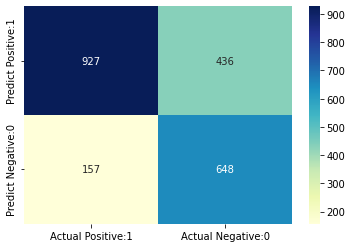

In [ ]:
# import SVC classifier
from sklearn.svm import SVC

# instantiate classifier with default hyperparameters
svc=SVC() 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(svc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y_pred,y)

In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(svc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.7264652355764626
precision: 0.805226329900553
auc: 0.8076844438781409
recall: 0.5977342549923195
f1: 0.6856384053392064
TIME: 0.026225273683333702 min


## Random Forest Classifier

TIME: 0.02187899398333381 min


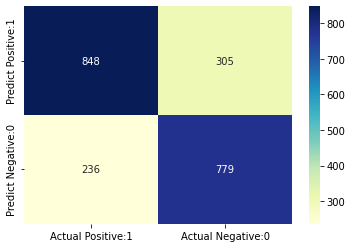

In [ ]:
# import RF classifier
from sklearn.ensemble import RandomForestClassifier

# instantiate classifier with default hyperparameters
rfc=RandomForestClassifier() 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(rfc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y_pred,y)


In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(rfc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.7518406572939836
precision: 0.7634605883920433
auc: 0.8321355718839738
recall: 0.7296850998463902
f1: 0.745936798174095
TIME: 0.03330821155000005 min


## Gradient Boosting Classifier

TIME: 0.03496018013333355 min


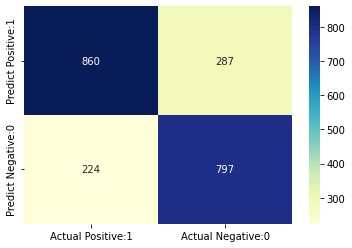

In [ ]:
# import GBT classifier
from sklearn.ensemble import GradientBoostingClassifier

# instantiate classifier with default hyperparameters
gbc=GradientBoostingClassifier() 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(gbc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y_pred,y)


In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(gbc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.766134885750471
precision: 0.7802610032980561
auc: 0.8589250713581768
recall: 0.7417008021846732
f1: 0.7604019024008675
TIME: 0.029566703750000065 min


## Logistic Regression

TIME: 0.006378947716666516 min


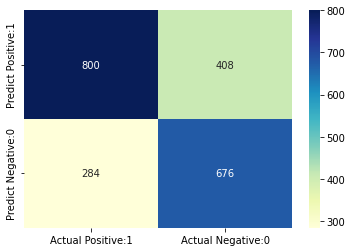

In [ ]:
# import log classifier
from sklearn.linear_model import LogisticRegressionCV

# instantiate classifier with default hyperparameters
lrc=LogisticRegressionCV(Cs=1) 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(lrc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y_pred,y)

In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(lrc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.6808069305350092
precision: 0.7043995782778311
auc: 0.7477332324998447
recall: 0.6235919098822325
f1: 0.6613432666066138
TIME: 0.008021808466666395 min
